In [1]:
from turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time

D:\Anaconda\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-

In [413]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle','Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction):

        self.scene = scene
        self.target_label = target_label
        self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
        junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary[junction])

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))
#         lane_list = ['/24B','nXc0','TG2b',"zHjP","SxVb","bH1o","MV/U","ZnUV","FV1O","dddQ","TZZv","6p63",'vC8o','SD8o']
        
        lane_list = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']


        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()

In [414]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [401]:
polygon = Polygon([(500,-2420),(500,-2360),(560,-2360),(560,-2420)])
scene_list = []

for scene in tqdm(range(len(zarr_dataset.scenes))):
    
    frame_start = zarr_dataset.scenes[scene]['frame_index_interval'][0]
    frame_end = zarr_dataset.scenes[scene]['frame_index_interval'][1]-1
    
    yaw_start = rotation33_as_yaw(zarr_dataset.frames[frame_start]['ego_rotation'])
    yaw_end = rotation33_as_yaw(zarr_dataset.frames[frame_end]['ego_rotation'])
    
    point_start = Point(zarr_dataset.frames[frame_start]['ego_translation'][0], zarr_dataset.frames[frame_start]['ego_translation'][1])
    point_end = Point(zarr_dataset.frames[frame_end]['ego_translation'][0], zarr_dataset.frames[frame_end]['ego_translation'][1])
    
    if polygon.contains(point_start)or polygon.contains(point_end):
        if abs(yaw_start-1.8465288407380713) <0.3 or abs(yaw_end+1.2950638127619287)<0.3:
            scene_list.append(scene)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16265/16265 [01:22<00:00, 197.34it/s]


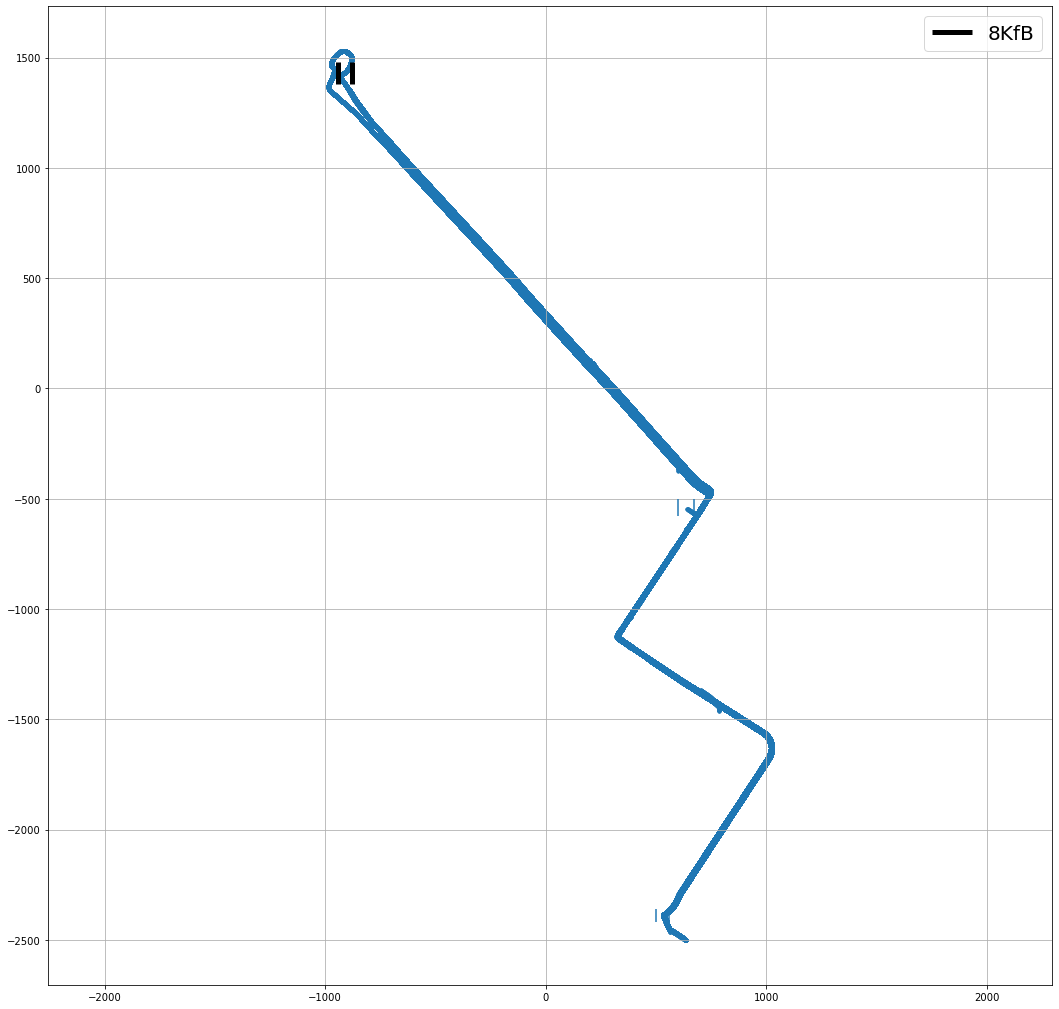

In [420]:
plt.figure(figsize=(18,18))
plt.scatter(Test.frames["ego_translation"][:,0], Test.frames["ego_translation"][:,1], marker='.')
plt.scatter(Test.frames["ego_translation"][Test.tunring_frames,0], Test.frames["ego_translation"][Test.tunring_frames,1], marker='.', color='r')
plt.axis("equal")
plt.grid(which='both')
plt.vlines(500, -2420, -2360)
plt.vlines(560, -2420, -2360)
plt.vlines(600, -500, -580)
plt.vlines(670, -500, -580)
# plt.vlines(-1000, 1300, 1380)
# plt.vlines(-930, 1300, 1380)
plt.vlines(-940, 1380, 1480, label = '8KfB',color='k',linewidth=5)
plt.vlines(-880, 1380, 1480,color='k',linewidth=5)
plt.legend(fontsize=20)
axes = plt.gca()

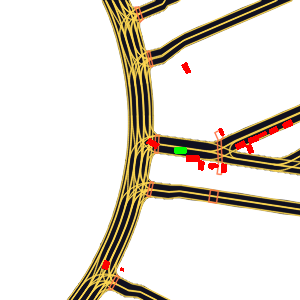

In [417]:
Test.scene_visualize(15646, ego_dataset, cfg)

In [415]:
scene_pedestrian = []

for scene in tqdm(scene_list):
    scene_pedestrian += Test.agent_trajectory(scene, 'Pedestrian', '8KfB')
    
scene_pedestrian

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:08<00:00, 23.94it/s]


[82,
 347,
 380,
 924,
 978,
 1041,
 1274,
 1571,
 1656,
 1861,
 2024,
 2046,
 2097,
 2148,
 2208,
 2209,
 2387,
 2582,
 2725,
 2838,
 3080,
 3134,
 3193,
 3435,
 3470,
 3518,
 3608,
 3609,
 3657,
 3658,
 3716,
 3774,
 3775,
 3873,
 4990,
 5021,
 5022,
 5081,
 5082,
 5366,
 5367,
 5423,
 5532,
 5582,
 5781,
 5844,
 5900,
 5958,
 6014,
 6095,
 6328,
 6409,
 6472,
 6730,
 6731,
 7032,
 7033,
 7092,
 7154,
 7192,
 7244,
 7356,
 7411,
 7463,
 7485,
 7539,
 7639,
 7641,
 7828,
 7920,
 7980,
 8071,
 8121,
 8170,
 8328,
 8434,
 8486,
 8538,
 8952,
 9006,
 9063,
 9115,
 9211,
 9250,
 9351,
 10106,
 10292,
 10446,
 10949,
 11177,
 11233,
 11462,
 11593,
 11639,
 11691,
 11859,
 11971,
 12034,
 12160,
 12284,
 12606,
 12926,
 12980,
 13043,
 13066,
 13390,
 13448,
 13449,
 13544,
 13597,
 13712,
 13811,
 13812,
 13916,
 13965,
 14013,
 14168,
 14221,
 14275,
 14371,
 14423,
 14670,
 14726,
 14776,
 14823,
 14881,
 14934,
 15023,
 15073,
 15198,
 15246,
 15291,
 15449,
 15497,
 15599,
 15600,
 15

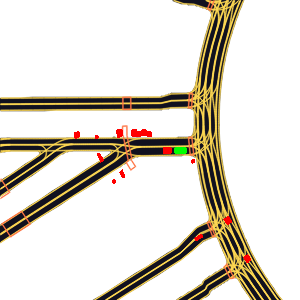

KeyboardInterrupt: 

In [316]:
import time


start = time.time()
for idx, valid_scene in enumerate(scene_pedestrian):
    Test.scene_visualize(valid_scene,ego_dataset,cfg)
    print('Current scene is ',idx)
    time.sleep(1)
    
end = time.time()
print(end-start)

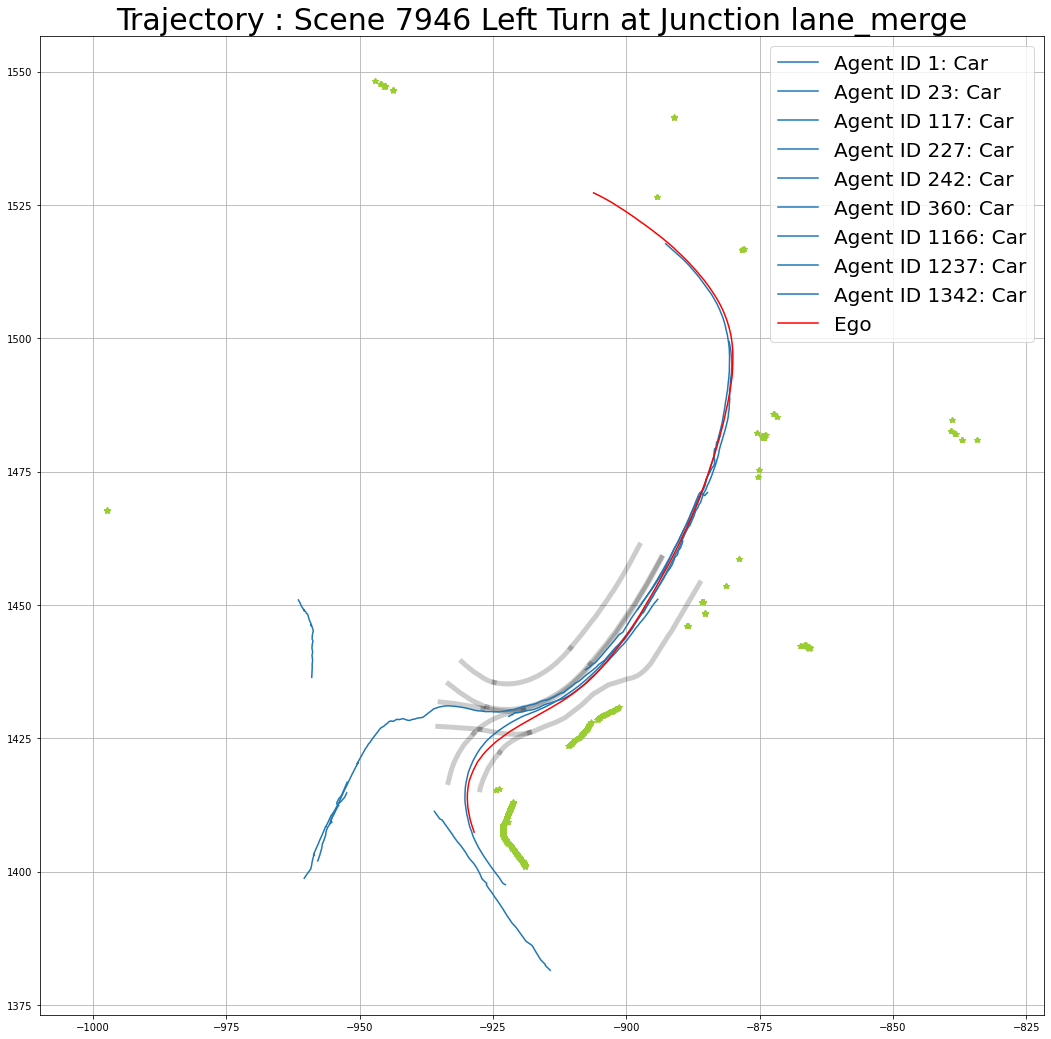

In [400]:
scene = 7946

Test.agent_trajectory(scene, 'Pedestrian', 'lane_merge')
Test.trajectory_junction_visualize(scene, 'Pedestrian', 'lane_merge')

Text(0.5, 1.0, 'Lane Merge')

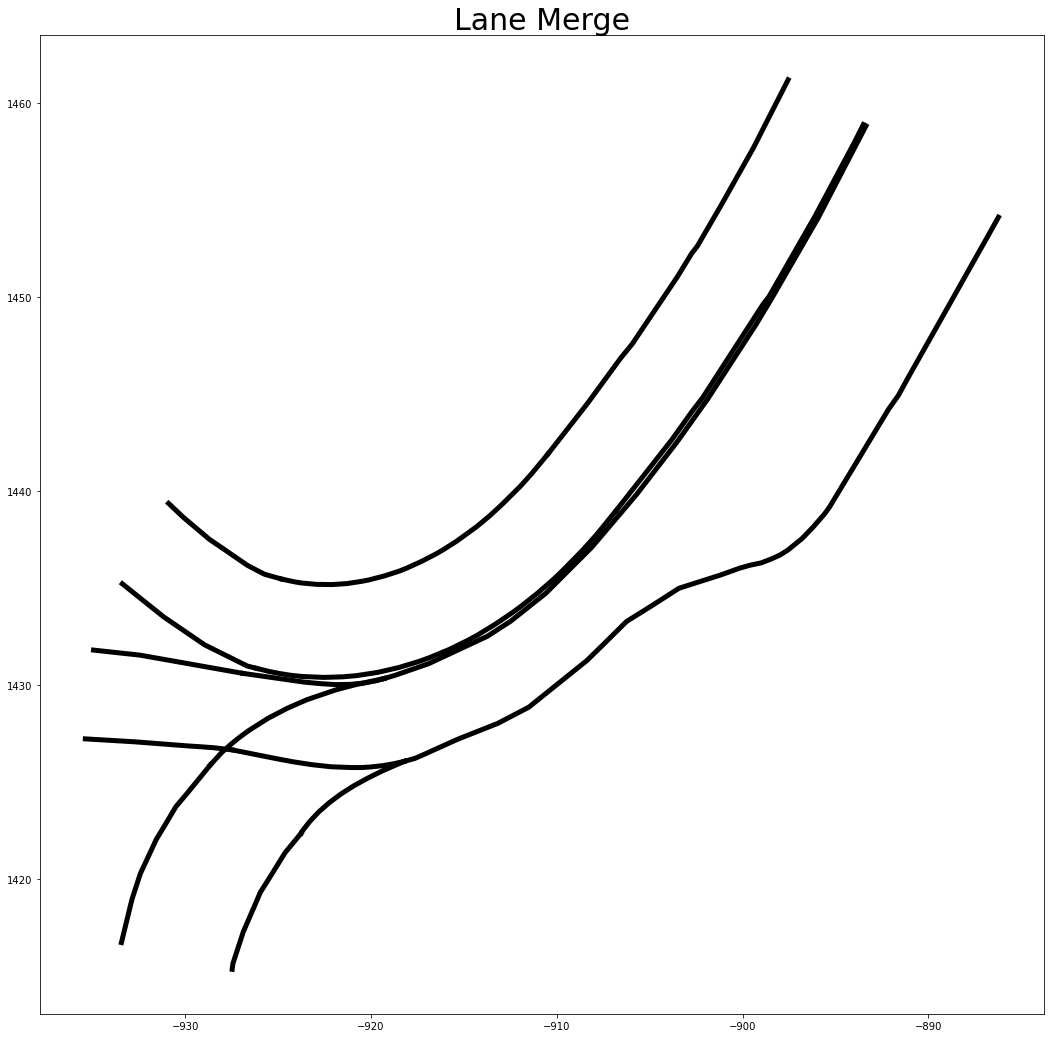

In [356]:
plt.figure(figsize=(18,18))
lane_list = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']



for lane in lane_list:
    plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
             color='k',linewidth=5,label=lane)
    plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
             color='k',linewidth=5)
    
plt.title('Lane Merge',fontsize=30)

# Find the scene index which are at the intersection: 'sGK1'

In [ ]:
scene_pedestrian = []

for scene in tqdm(target_junction):
    scene_pedestrian += Test.agent_trajectory(scene, 'Pedestrian', 'sGK1', ego_dataset)
    
scene_pedestrian

In [ ]:
import time


start = time.time()
for idx, valid_scene in enumerate(scene_pedestrian):
    Test.scene_visualize(valid_scene,ego_dataset,cfg)
    print('Current scene is ',idx)
    time.sleep(1)
    
end = time.time()
print(end-start)

In [ ]:
invalid_scene_idx = [1,2,3,6,10,13,15,16,17,19,33,37,39,40,42,54,55,57,58,66,68,70,71,73,74,85,91,92,96,97,101,103,110,111,113,114,116,118,128,130,134,135,140,141,142,148,151,152,156,161,162,163,167,167,190]

In [ ]:
target_scene_index = []
nontarget_scene_index = []
for index, value in enumerate(scene_pedestrian):
    
    if index in invalid_scene_idx:
        nontarget_scene_index.append(value)
    else:
        target_scene_index.append(value)

In [ ]:
scene_index = np.load("D:\\GitHub\\Clone\\planning\\ruixuan\\target_scene_index\\target_scene_index.npy",allow_pickle=True)

# Extract the vehicle type agents' trajectories

In [102]:
from tqdm import tqdm
vehicle_trajectory = []

for scene_idx in tqdm(range(2500)):
    
    scene = zarr_dataset.scenes[scene_idx]
    frames = scene['frame_index_interval']
    frame_begin = zarr_dataset.frames[frames[0]]
    frame_end = zarr_dataset.frames[frames[1]-1]
    agents = zarr_dataset.agents[frame_begin['agent_index_interval'][0]:frame_end['agent_index_interval'][1]]

    # filter out the agents that are sastified the demand

    agents = agents[agents['label_probabilities'][:,[3,5,6,7,8,9]].sum(axis=1) == 1]
    agents_id = set(agents['track_id'])
    
    for idx in agents_id:
    
        # the reason to use 6:-5 is because some perception results are strange
        if agents[agents['track_id']==idx][6:-5].shape[0] >= 50:
            agent_info = agents[agents['track_id']==idx][5:-5]
            agent_centroid = agent_info[1:]['centroid'][::5]
            agent_velocity = np.linalg.norm(agent_info['velocity'], axis =1)
            agent_acceleration = np.diff(agent_velocity)[::5]/0.1
            agent_velocity = agent_velocity[1:][::5]

            num = agent_info[1:][::5].shape[0]//10

            for i in range(num):
                centroid = agent_centroid[i:i+10]
                velocity = agent_velocity[i:i+10][:,np.newaxis]
                acceleration = agent_acceleration[i:i+10][:,np.newaxis]
                instance = np.hstack((centroid,velocity,acceleration))

                vehicle_trajectory.append(instance)
                
vehicle_trajectory = np.array(vehicle_trajectory)

  0%| | 0/

0


  0%| | 10

1
2
3
4
5
6
7
8
9
10
11
12
13
14


  1%| | 16

15
16
17
18
19
20


  1%| | 27

21
22
23
24
25
26
27
28
29
30
31


  1%| | 37

32
33
34
35
36
37
38

  2%| | 41


39
40
41
42
43
44
45
46
47
48
49
50
51


  2%| | 59

52
53
54
55
56
57
58
59
60
61


  3%| | 65

62
63
64
65
66
67


  3%| | 70

68
69
70
71
72
73
74


  3%| | 85

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


  4%| | 98

90
91
92
93
94
95
96
97
98
99


  4%| | 10

100
101
102
103
104
105


  5%| | 11

106
107
108
109
110
111
112
113


  5%| | 11

114
115
116
117
118
119
120
121
122


  5%| | 13

123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


  6%| | 14

138
139
140
141
142
143
144
145
146
147
148


  6%| | 15

149
150
151
152
153
154
155

  6%| | 15


156
157
158
159


  6%| | 16

160
161
162
163
164


  7%| | 16

165
166
167
168
169


  7%| | 17

170
171
172
173
174
175
176
177
178


  7%| | 18

179
180
181
182
183
184
185
186
187
188
189
190
191


  8%| | 19

192
193
194
195
196
197
198
199


  8%| | 20

200
201
202
203


  8%| | 21

204
205
206
207
208
209


  9%| | 21

210
211
212
213
214
215
216


  9%| | 23

217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


 10%| | 24

234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


 10%| | 25

249
250
251
252
253
254
255


 10%| | 25

256
257
258
259
260


 11%| | 27

261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


 11%| | 28

277
278
279
280
281
282
283
284
285
286
287


 12%| | 29

288
289
290
291
292
293


 12%| | 29

294
295
296
297
298
299
300
301


 12%| | 30

302
303
304
305
306
307
308


 13%|▏| 31

309
310
311
312
313
314
315
316
317
318
319
320
321
322


 13%|▏| 32

323
324
325
326
327
328


 13%|▏| 33

329
330
331
332
333
334
335


 14%|▏| 34

336
337
338
339
340
341
342
343
344
345
346
347
348


 14%|▏| 36

349
350
351
352
353
354
355
356
357
358
359
360
361


 15%|▏| 36

362
363
364
365
366
367


 15%|▏| 37

368
369
370
371
372
373
374
375
376


 15%|▏| 38

377
378
379
380
381
382
383
384
385
386
387


 16%|▏| 39

388
389
390
391
392
393
394
395


 16%|▏| 40

396
397
398
399
400
401


 16%|▏| 40

402
403
404
405
406
407
408


 16%|▏| 41

409
410
411


 17%|▏| 41

412
413
414
415
416
417
418
419
420


 17%|▏| 42

421
422
423
424

 17%|▏| 42


425
426
427
428


 17%|▏| 43

429
430
431
432
433
434


 18%|▏| 44

435
436
437
438
439
440
441
442
443
444
445


 18%|▏| 45

446
447
448
449
450
451


 18%|▏| 45

452
453
454
455
456
457
458
459


 18%|▏| 46

460
461
462
463


 19%|▏| 46

464
465
466
467
468


 19%|▏| 47

469
470
471
472
473
474


 19%|▏| 48

475
476
477
478
479
480
481
482
483
484
485

 19%|▏| 48


486
487
488


 20%|▏| 49

489
490
491
492
493
494


 20%|▏| 49

495
496
497
498
499


 20%|▏| 50

500
501
502
503
504
505
506


 20%|▏| 51

507
508
509
510


 21%|▏| 51

511
512
513
514
515
516
517
518


 21%|▏| 52

519
520
521
522
523
524
525
526
527
528
529
530


 21%|▏| 53

531
532
533
534
535


 21%|▏| 53

536
537
538
539
540


 22%|▏| 54

541
542
543
544
545
546
547


 22%|▏| 55

548
549
550
551
552
553
554
555
556
557
558


 23%|▏| 56

559
560
561
562
563
564
565
566


 23%|▏| 57

567
568
569
570
571


 23%|▏| 57

572
573
574
575
576
577
578
579


 23%|▏| 58

580
581
582
583
584


 24%|▏| 58

585
586
587
588
589
590


 24%|▏| 59

591
592
593
594
595
596
597
598
599
600
601


 24%|▏| 60

602
603
604
605
606
607


 24%|▏| 61

608
609
610
611
612
613
614
615
616


 25%|▏| 62

617
618
619
620
621
622


 25%|▎| 63

623
624
625
626
627
628
629
630
631
632
633
634
635
636
637


 26%|▎| 64

638
639
640
641
642
643
644


 26%|▎| 64

645
646
647
648
649
650


 26%|▎| 65

651
652
653
654
655
656
657
658
659


 27%|▎| 66

660
661
662
663
664


 27%|▎| 67

665
666
667
668
669
670
671
672
673
674
675
676


 27%|▎| 67

677
678
679
680
681
682


 28%|▎| 68

683
684
685
686
687
688


 28%|▎| 69

689
690
691


 28%|▎| 69

692
693
694
695
696
697
698
699
700
701


 28%|▎| 70

702
703
704
705
706
707
708
709
710


 29%|▎| 72

711
712
713
714
715
716
717
718
719
720
721
722
723


 29%|▎| 72

724
725
726
727
728
729
730


 29%|▎| 73

731
732
733
734


 30%|▎| 74

735
736
737
738
739
740
741
742
743


 30%|▎| 74

744
745
746
747
748
749


 30%|▎| 76

750
751
752
753
754
755
756
757
758
759
760
761
762


 31%|▎| 76

763
764
765
766
767
768
769
770
771
772


 31%|▎| 77

773
774
775
776
777
778
779


 31%|▎| 78

780
781
782


 32%|▎| 78

783
784
785
786
787
788
789
790
791
792
793


 32%|▎| 79

794
795
796
797
798


 32%|▎| 80

799
800
801
802
803
804
805
806
807
808


 33%|▎| 81

809
810
811
812
813
814
815
816
817
818
819
820
821


 33%|▎| 83

822
823
824
825
826
827
828
829
830
831


 33%|▎| 83

832
833
834
835
836
837
838
839
840


 34%|▎| 84

841
842
843
844
845
846
847
848
849
850
851
852
853


 34%|▎| 86

854
855
856
857
858
859
860
861
862
863
864


 35%|▎| 87

865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880


 35%|▎| 88

881
882
883
884
885
886
887


 36%|▎| 89

888
889
890
891
892
893
894
895


 36%|▎| 90

896
897
898
899
900
901
902
903
904
905
906
907
908


 36%|▎| 91

909
910
911
912
913
914
915
916


 37%|▎| 92

917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933


 37%|▎| 93

934
935
936
937
938
939
940
941
942


 38%|▍| 94

943
944
945
946
947
948
949
950


 38%|▍| 95

951
952
953
954
955
956
957
958
959


 39%|▍| 96

960
961
962
963
964
965
966
967


 39%|▍| 98

968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985


 40%|▍| 99

986
987
988
989
990
991
992
993
994
995
996


 40%|▍| 99

997
998
999
1000
1001
1002
1003


 40%|▍| 10

1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016


 41%|▍| 10

1017
1018
1019
1020
1021
1022
1023


 41%|▍| 10

1024
1025
1026
1027
1028
1029
1030
1031
1032
1033


 42%|▍| 10

1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052


 42%|▍| 10

1053
1054
1055
1056
1057
1058
1059


 43%|▍| 10

1060
1061
1062
1063
1064
1065
1066


 43%|▍| 10

1067
1068
1069
1070
1071
1072
1073
1074
1075
1076


 43%|▍| 10

1077
1078
1079
1080
1081
1082
1083


 44%|▍| 10

1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101

 44%|▍| 11


1102
1103
1104
1105
1106


 44%|▍| 11

1107
1108
1109
1110
1111
1112
1113
1114
1115


 45%|▍| 11

1116
1117
1118
1119
1120
1121
1122
1123
1124
1125


 45%|▍| 11

1126
1127
1128
1129
1130
1131


 46%|▍| 11

1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145


 46%|▍| 11

1146
1147
1148
1149
1150
1151
1152
1153


 46%|▍| 11

1154
1155
1156
1157
1158


 46%|▍| 11

1159
1160
1161
1162
1163
1164
1165
1166
1167


 47%|▍| 11

1168
1169
1170
1171
1172


 47%|▍| 11

1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188


 48%|▍| 12

1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202


 48%|▍| 12

1203
1204
1205
1206
1207
1208


 49%|▍| 12

1209
1210
1211
1212
1213
1214
1215
1216
1217
1218


 49%|▍| 12

1219
1220
1221
1222
1223
1224
1225


 49%|▍| 12

1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236


 50%|▍| 12

1237
1238
1239
1240
1241
1242
1243
1244
1245
1246


 50%|▌| 12

1247
1248
1249
1250
1251
1252
1253
1254


 50%|▌| 12

1255
1256
1257
1258
1259


 50%|▌| 12

1260
1261
1262


 51%|▌| 12

1263
1264


 51%|▌| 12

1265
1266
1267
1268
1269
1270


 51%|▌| 12

1271
1272
1273
1274
1275
1276
1277
1278


 51%|▌| 12

1279
1280
1281
1282
1283
1284


 52%|▌| 12

1285
1286
1287
1288
1289
1290
1291
1292


 52%|▌| 12

1293
1294
1295
1296


 52%|▌| 12

1297
1298
1299


 52%|▌| 13

1300
1301
1302
1303
1304
1305
1306


 52%|▌| 13

1307
1308
1309
1310
1311
1312
1313
1314
1315
1316


 53%|▌| 13

1317
1318
1319
1320


 53%|▌| 13

1321
1322
1323
1324
1325
1326
1327
1328


 53%|▌| 13

1329
1330
1331
1332
1333
1334
1335
1336


 54%|▌| 13

1337
1338
1339
1340
1341
1342
1343


 54%|▌| 13

1344
1345
1346
1347
1348
1349
1350
1351
1352
1353


 54%|▌| 13

1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364

 55%|▌| 13


1365
1366
1367


 55%|▌| 13

1368
1369
1370
1371
1372
1373
1374
1375
1376
1377


 55%|▌| 13

1378
1379
1380
1381
1382
1383


 56%|▌| 13

1384
1385
1386
1387
1388
1389
1390
1391
1392


 56%|▌| 13

1393
1394
1395
1396
1397
1398
1399


 56%|▌| 14

1400
1401
1402
1403
1404
1405
1406
1407


 57%|▌| 14

1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420


 57%|▌| 14

1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433


 57%|▌| 14

1434
1435
1436
1437
1438
1439
1440
1441
1442


 58%|▌| 14

1443
1444
1445


 58%|▌| 14

1446
1447
1448
1449
1450
1451
1452
1453
1454
1455


 58%|▌| 14

1456
1457
1458
1459
1460
1461


 59%|▌| 14

1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475


 59%|▌| 14

1476
1477
1478
1479
1480
1481
1482


 59%|▌| 14

1483
1484
1485
1486
1487


 60%|▌| 14

1488
1489
1490
1491
1492
1493
1494
1495
1496


 60%|▌| 15

1497
1498
1499
1500
1501
1502
1503


 61%|▌| 15

1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520


 61%|▌| 15

1521
1522
1523
1524
1525
1526
1527
1528


 61%|▌| 15

1529
1530
1531
1532
1533
1534
1535


 62%|▌| 15

1536
1537
1538
1539
1540
1541
1542


 62%|▌| 15

1543
1544
1545
1546
1547
1548
1549


 62%|▌| 15

1550
1551
1552
1553


 62%|▌| 15

1554
1555
1556
1557
1558


 63%|▋| 15

1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569


 63%|▋| 15

1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588


 64%|▋| 15

1589
1590
1591
1592
1593
1594
1595
1596
1597
1598


 64%|▋| 16

1599
1600
1601
1602


 64%|▋| 16

1603
1604
1605
1606
1607
1608
1609
1610


 65%|▋| 16

1611
1612
1613
1614
1615
1616
1617


 65%|▋| 16

1618
1619
1620
1621
1622
1623


 65%|▋| 16

1624
1625
1626
1627
1628
1629


 65%|▋| 16

1630
1631
1632
1633
1634
1635
1636
1637
1638


 66%|▋| 16

1639
1640
1641
1642
1643
1644
1645


 66%|▋| 16

1646
1647
1648
1649
1650
1651
1652


 66%|▋| 16

1653
1654
1655
1656
1657
1658
1659
1660
1661
1662


 67%|▋| 16

1663
1664
1665
1666
1667
1668
1669
1670
1671
1672


 67%|▋| 16

1673
1674
1675
1676
1677
1678
1679
1680


 67%|▋| 16

1681
1682
1683


 68%|▋| 16

1684
1685
1686
1687
1688
1689
1690
1691
1692

 68%|▋| 16


1693
1694
1695
1696
1697


 68%|▋| 17

1698
1699
1700
1701
1702
1703
1704
1705
1706


 69%|▋| 17

1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723


 69%|▋| 17

1724
1725
1726
1727
1728
1729
1730


 69%|▋| 17

1731
1732
1733
1734
1735


 70%|▋| 17

1736
1737
1738
1739
1740
1741
1742
1743
1744


 70%|▋| 17

1745
1746
1747
1748
1749
1750
1751
1752
1753

 71%|▋| 17


1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776


 71%|▋| 17

1777
1778
1779
1780
1781


 71%|▋| 17

1782
1783
1784
1785
1786
1787
1788
1789
1790
1791


 72%|▋| 17

1792
1793
1794
1795
1796
1797
1798


 72%|▋| 18

1799
1800
1801
1802
1803
1804
1805


 73%|▋| 18

1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818


 73%|▋| 18

1819
1820
1821
1822
1823
1824
1825
1826
1827


 73%|▋| 18

1828
1829
1830
1831


 74%|▋| 18

1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842


 74%|▋| 18

1843
1844
1845
1846
1847
1848
1849


 74%|▋| 18

1850
1851
1852
1853
1854
1855
1856


 75%|▋| 18

1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873


 75%|▊| 18

1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884


 76%|▊| 18

1885
1886
1887
1888
1889
1890
1891
1892
1893
1894


 76%|▊| 19

1895
1896
1897
1898
1899
1900
1901


 76%|▊| 19

1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912


 77%|▊| 19

1913
1914
1915
1916
1917
1918
1919
1920
1921


 77%|▊| 19

1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933


 77%|▊| 19

1934
1935
1936
1937
1938
1939


 78%|▊| 19

1940
1941
1942
1943
1944
1945
1946
1947


 78%|▊| 19

1948
1949
1950
1951
1952
1953
1954
1955
1956


 78%|▊| 19

1957
1958
1959
1960
1961
1962
1963


 79%|▊| 19

1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977

 79%|▊| 19


1978
1979
1980
1981
1982
1983
1984
1985
1986


 80%|▊| 19

1987
1988
1989
1990
1991


 80%|▊| 20

1992
1993
1994
1995
1996
1997
1998
1999
2000
2001


 80%|▊| 20

2002
2003
2004
2005
2006
2007
2008


 80%|▊| 20

2009
2010
2011
2012
2013
2014


 81%|▊| 20

2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031


 82%|▊| 20

2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048


 82%|▊| 20

2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


 83%|▊| 20

2064
2065
2066
2067


 83%|▊| 20

2068
2069
2070
2071
2072
2073
2074


 83%|▊| 20

2075
2076
2077
2078
2079
2080
2081


 83%|▊| 20

2082
2083
2084
2085
2086
2087
2088
2089


 84%|▊| 20

2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102


 84%|▊| 21

2103
2104
2105
2106
2107
2108
2109
2110
2111


 85%|▊| 21

2112
2113
2114
2115
2116
2117
2118
2119
2120


 85%|▊| 21

2121
2122
2123
2124
2125
2126
2127


 85%|▊| 21

2128
2129
2130
2131
2132


 86%|▊| 21

2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143


 86%|▊| 21

2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157


 86%|▊| 21

2158
2159
2160
2161
2162


 87%|▊| 21

2163
2164
2165
2166
2167
2168
2169
2170


 87%|▊| 21

2171
2172
2173
2174


 87%|▊| 21

2175
2176
2177
2178
2179
2180
2181
2182


 88%|▉| 21

2183
2184
2185
2186
2187
2188
2189
2190


 88%|▉| 21

2191
2192
2193
2194
2195
2196
2197


 88%|▉| 22

2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210


 89%|▉| 22

2211
2212
2213
2214
2215
2216
2217
2218


 89%|▉| 22

2219
2220
2221
2222
2223
2224
2225
2226
2227
2228


 89%|▉| 22

2229
2230
2231
2232
2233


 89%|▉| 22

2234
2235
2236
2237
2238
2239
2240
2241
2242


 90%|▉| 22

2243
2244
2245
2246
2247
2248
2249
2250


 90%|▉| 22

2251
2252
2253
2254
2255


 90%|▉| 22

2256
2257
2258
2259


 90%|▉| 22

2260
2261
2262


 91%|▉| 22

2263
2264
2265
2266


 91%|▉| 22

2267
2268


 91%|▉| 22

2269
2270
2271
2272


 91%|▉| 22

2273
2274
2275


 91%|▉| 22

2276
2277
2278


 91%|▉| 22

2279
2280
2281


 91%|▉| 22

2282
2283
2284
2285


 91%|▉| 22

2286
2287
2288
2289


 92%|▉| 22

2290
2291


 92%|▉| 22

2292


 92%|▉| 22

2293
2294


 92%|▉| 22

2295
2296


 92%|▉| 22

2297
2298


 92%|▉| 23

2299
2300


 92%|▉| 23

2301
2302
2303


 92%|▉| 23

2304
2305


 92%|▉| 23

2306
2307


 92%|▉| 23

2308
2309


 92%|▉| 23

2310
2311
2312


 93%|▉| 23

2313
2314
2315
2316


 93%|▉| 23

2317
2318


 93%|▉| 23

2319
2320
2321


 93%|▉| 23

2322
2323
2324


 93%|▉| 23

2325
2326
2327
2328


 93%|▉| 23

2329
2330
2331


 93%|▉| 23

2332
2333


 93%|▉| 23

2334


 93%|▉| 23

2335
2336
2337
2338


 94%|▉| 23

2339
2340
2341


 94%|▉| 23

2342


 94%|▉| 23

2343
2344
2345


 94%|▉| 23

2346
2347
2348


 94%|▉| 23

2349
2350


 94%|▉| 23

2351


 94%|▉| 23

2352
2353


 94%|▉| 23

2354
2355
2356


 94%|▉| 23

2357
2358
2359


 94%|▉| 23

2360
2361
2362


 95%|▉| 23

2363
2364
2365
2366


 95%|▉| 23

2367
2368
2369


 95%|▉| 23

2370
2371


 95%|▉| 23

2372
2373
2374


 95%|▉| 23

2375
2376


 95%|▉| 23

2377
2378
2379


 95%|▉| 23

2380
2381
2382


 95%|▉| 23

2383
2384
2385

 95%|▉| 23


2386
2387


 96%|▉| 23

2388
2389
2390
2391


 96%|▉| 23

2392
2393
2394
2395


 96%|▉| 23

2396
2397


 96%|▉| 23

2398
2399


 96%|▉| 24

2400
2401


 96%|▉| 24

2402
2403
2404


 96%|▉| 24

2405


 96%|▉| 24

2406
2407


 96%|▉| 24

2408
2409


 96%|▉| 24

2410
2411


 96%|▉| 24

2412


 97%|▉| 24

2413
2414


 97%|▉| 24

2415


 97%|▉| 24

2416
2417
2418


 97%|▉| 24

2419
2420
2421


 97%|▉| 24

2422
2423


 97%|▉| 24

2424
2425
2426
2427


 97%|▉| 24

2428
2429


 97%|▉| 24

2430
2431
2432


 97%|▉| 24

2433
2434
2435


 97%|▉| 24

2436
2437


 98%|▉| 24

2438
2439
2440


 98%|▉| 24

2441
2442
2443


 98%|▉| 24

2444
2445
2446


 98%|▉| 24

2447
2448


 98%|▉| 24

2449
2450


 98%|▉| 24

2451
2452


 98%|▉| 24

2453


 98%|▉| 24

2454
2455
2456


 98%|▉| 24

2457
2458
2459
2460


 99%|▉| 24

2461
2462


 99%|▉| 24

2463
2464
2465


 99%|▉| 24

2466
2467


 99%|▉| 24

2468
2469
2470


 99%|▉| 24

2471


 99%|▉| 24

2472
2473


 99%|▉| 24

2474
2475
2476


 99%|▉| 24

2477
2478


 99%|▉| 24

2479
2480


 99%|▉| 24

2481
2482


 99%|▉| 24

2483
2484
2485


 99%|▉| 24

2486
2487
2488


100%|▉| 24

2489
2490
2491


100%|▉| 24

2492
2493


100%|▉| 24

2494
2495


100%|▉| 24

2496
2497
2498


100%|█| 25


2499


In [110]:
np.save('Vehicle_trajectory.npy',vehicle_trajectory)

In [109]:
import pickle

output = open('Vehicle_trajectory.pickle', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(vehicle_trajectory, output)